###  Autor: Lilian Rebeca Carrera Lemus 
No. Carnet: 20008077  


# Práctica No. 1: K-means y Detección de Anomalías

### Parte 1: Clustering

* Utilizar los datos del archivo estaturas (primera pestaña) para implementar:
    * Hard-clustering con k-means (no usar sklearn)
    * Soft-clustering con GMM usando sklearn
* Ejecutar al menos 5 experimentos para seleccionar el valor de “K”
    * Ambos métodos pueden usar el mismo valor de “K”
    * Analizar el centroide de cada clúster y determinar si es posible asignar una categoría  cada clúster
* Analizar y concluir si el método del codo es adecuado para este problema
* Usar los datos en la segunda pestaña y estimar:
    * El clúster que k-means asigna cada uno.
    * La probabilidad de pertenecer a cada clúster según GMM


In [1]:
#Librerías a utilizar
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [2]:
#Cargamos los datos a utilizar del archivo de Excel
data_train = pd.read_excel('estaturas.xlsx', sheet_name='normales')
data_test = pd.read_excel('estaturas.xlsx', sheet_name='valtest(normales)')
data_anomalias = pd.read_excel('estaturas.xlsx', sheet_name='anomalias')
data_train.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


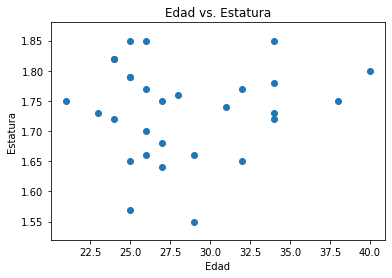

In [3]:
#Analizar los datos proporcionados
plt.scatter(data_train['Edad(años)'], data_train['Estatura(metros)'])
plt.title("Edad vs. Estatura")
plt.xlabel("Edad")
plt.ylabel("Estatura")
plt.show()

### Implementación de Hard-clustering con k-means (no usar sklearn)

In [4]:
# Funcion para obtener los valores aleatorios
#Para generar los número aleatorios los convertimos a entero para que sea más fácil trabajar con numpy
def valores_random(minimo,maximo):
    valor_random = np.random.randint(1,100)
    valor = (maximo-minimo)/100
    posicion = valor * valor_random
    resultado = float(minimo + posicion)
    return resultado

In [5]:
#Función para asignar una observación de los datos a un cluster mediante el cálculo de la distancia menor respecto del centroide
def asignacion(data, centroides, colores):
        for i in centroides.keys():
            data['distancia_desde_{}'.format(i)] = (np.sqrt((data['Estatura(metros)'] - centroides[i][0])**2 + (data['Edad(años)'] - centroides[i][1])**2 ))
            
        distancia_centroides = ['distancia_desde_{}'.format(i) for i in centroides.keys()]
        data['distancia_menor'] = data.loc[:, distancia_centroides].idxmin(axis=1)
        data['distancia_menor'] = data['distancia_menor'].map(lambda x: int(x.lstrip('distancia_desde_')))
        data['color'] = data['distancia_menor'].map(lambda x: colores[x])
        return data

In [6]:
#Función para implementar k-means 
def k_means(k, data, semilla):
    #Estableceremos una semilla aleatoria para tener los mismos resultados
    np.random.seed(semilla)
    centroides = dict() #Diccionario para almacenar los centroides
    
    #Calculo de máximos y minimos para inicializar los centroides
    est_min = np.min(data_train['Estatura(metros)'])
    est_max= np.max(data_train['Estatura(metros)'])
    edad_min = np.min(data_train['Edad(años)'])
    edad_max= np.min(data_train['Edad(años)'])
    
    #Inicialización aleatoria de centroides
    for i in range(k):
        centroides[i+1]= [valores_random(est_min, est_max), valores_random(edad_min, edad_max)]
        
    colores = {1: 'blue', 2: 'green', 3: 'red', 4: 'orange', 5: 'purple', 6: 'pink'}
    
    # 1.Asignación de cluster
    data = asignacion(data, centroides, colores)

    # Copia de los centroides anteriores
    centroides_ant = copy.deepcopy(centroides)

    #Función para actualizar la ubicación de centroides
    def actualizar_centroides(k):
        for i in centroides.keys():
            centroides[i][0] = np.mean(data[data['distancia_menor'] == i]['Estatura(metros)'])
            centroides[i][1] = np.mean(data[data['distancia_menor'] == i]['Edad(años)'])
        return k

    #2.Reubicación de centroides
    centroides = actualizar_centroides(centroides)
    
    # Repetir hasta que ya no cambie 
    while True:
        centroides_cercanos = data['distancia_menor'].copy(deep=True)
        centroides = actualizar_centroides(centroides)
        data = asignacion(data, centroides, colores)
        if centroides_cercanos.equals(data['distancia_menor']):
            break
    
    #Calculo de la función de costo, función de distorsiónn
    suma_cuadrados = []
    for i in range(k):
        dist=data[data.distancia_menor==i+1]
        cuadrados=dist['distancia_desde_'+str(i+1)].mean()
        suma_cuadrados.append(cuadrados)
                  
    #Costo
    distorsion = np.min(suma_cuadrados)
    
    return data, centroides, colores, distorsion

In [7]:
#Funcion para graficar el modelo
def graficar_k_means(data, centroides, colores):
    #Graficamos los resultado
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(data['Edad(años)'], data['Estatura(metros)'], color=data['color'], alpha=0.5, edgecolor = 'k')
    centroides2=pd.DataFrame(centroides)
    centroides2 = centroides2.T
    centroides2.columns = ["altura","edad"]
    plt.scatter(centroides2["edad"], centroides2["altura"], color='black', s = 75)
    plt.xlim(15, 45)
    plt.ylim(1.40, 2.10)
    plt.title('K-means con K='+str(len(centroides)))
    plt.xlabel('Edad(años)')
    plt.ylabel('Estatura(metros)')
    plt.show()

#### Experimentos para seleccionar k

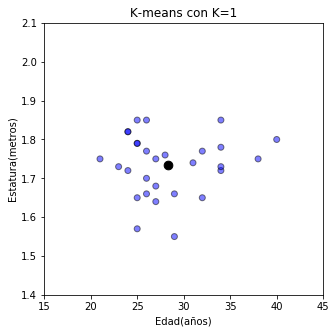

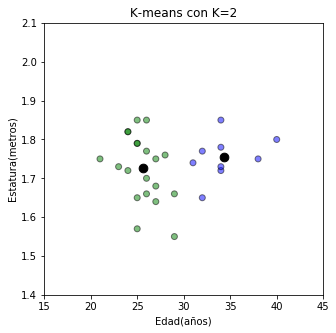

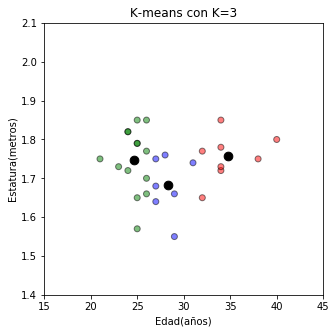

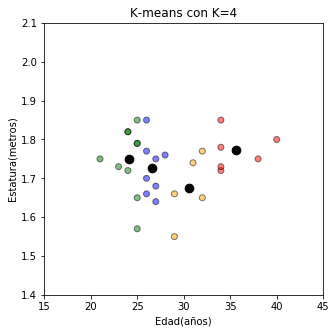

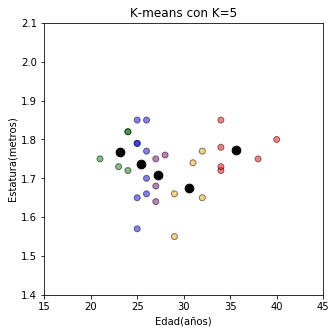

In [8]:
#Realizamos 6 experimentos y guardamos el costo para cada uno
lista_error = []
for i in range(1,6):
    df_salida, centroides, colores, distorsion = k_means(i,data_train, 140)
    lista_error.append(distorsion)
    graficar_k_means(df_salida, centroides, colores)

In [9]:
lista_error

[3.8352939257501086,
 1.5043202861040579,
 1.037094384232288,
 0.6289391283062982,
 0.3789705481374739]

Se ralizaron 5 experimientos para seleccionar el número de k óptimo, sin embargo no hay una mejor manera de elegirlo, si nos guiamos por el error mínimo de la función de costo el mejor k sería k= 5

### Implementación de Soft-clustering con GMM usando sklearn

In [10]:
data_train=pd.DataFrame(data_train, columns =["Estatura(metros)","Edad(años)"])
data_train.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


In [11]:
#Entrenamos el modelo utilizando el mismo k=5 del modelo anterior
modelo_gm = GaussianMixture(n_components = 5).fit(data_train)
etiquetas = modelo_gm.predict(data_train)

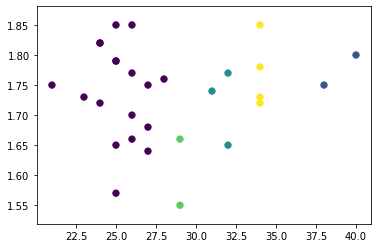

In [12]:
#Visualizamos los clusters generados
plt.scatter(data_train["Edad(años)"], data_train["Estatura(metros)"], c = etiquetas, s = 40, cmap = 'viridis')

In [13]:
# score de gmm
modelo_gm.score(data_train)

-0.10630269963943494

### Método del Codo para elegir un K óptimo

La idea básica de los algoritmos de clustering es la minimización de la varianza intra-cluster y la maximización de la varianza inter-cluster. Es decir, queremos que cada observación se encuentre muy cerca a las de su mismo grupo y los grupos lo más lejos posible entre ellos.

El método del codo utiliza la distancia media de las observaciones a su centroide. Es decir, se fija en las distancias intra-cluster. Cuanto más grande es el número de clusters k, la varianza intra-cluster tiende a disminuir. Cuanto menor es la distancia intra-cluster mejor, ya que significa que los clústers son más compactos. El método del codo busca el valor k que satisfaga que un incremento de k, no mejore sustancialmente la distancia media intra-cluster.

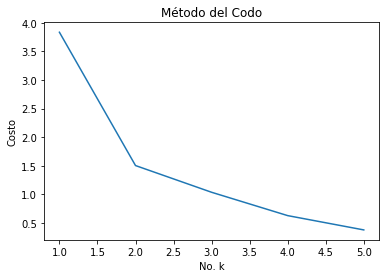

In [14]:
#Implementación Método del codo para el algoritmo generado de k-means
plt.plot(range(1, 6), lista_error)
plt.title('Método del Codo')
plt.xlabel('No. k')
plt.ylabel('Costo')
plt.show()

En este problema podemos utilizar el método del codo para determinar el número óptimo de k (clusters), ya que como se puede observar en la gráfica, la suma de las distancias disminuye conforme aumenta el número de clusters y esa disminución se va atenuando conforme aumentan los número de clusters. El punto en donde se hace un pequeño codo y el cambio en el valor de la suma de las distancias se reduce significativamente, es el valor que nos indica el número óptimo de clusters. En este caso el punto óptimo es 4, por lo cual se seleccionará un k=4.

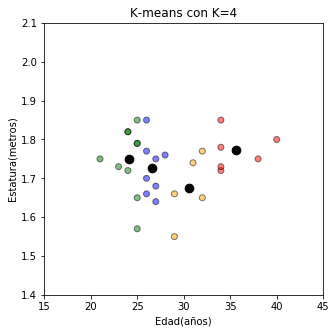

In [15]:
#Graficaremos y entrenaremos el modelo k-means desarrollado con el k seleccionado de acuerdo al método del codo
df_salida, centroides, colores, distorsion = k_means(4,data_train, 140)
graficar_k_means(df_salida, centroides, colores)

Text(0.5, 1.0, 'GMM con k = 4')

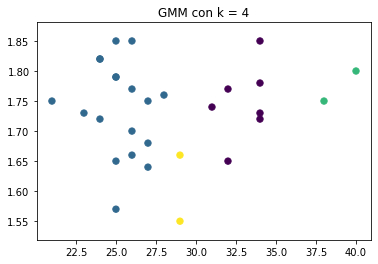

In [16]:
#Graficaremos y entrenaremos el modelo Gaussian Mixture con el k seleccionado de acuerdo al método del codo
data_train=pd.DataFrame(data_train, columns =["Estatura(metros)","Edad(años)"])
modelo_gm = GaussianMixture(n_components = 4).fit(data_train)
etiquetas = modelo_gm.predict(data_train)
plt.scatter(data_train["Edad(años)"], data_train["Estatura(metros)"], c = etiquetas, s = 40, cmap = 'viridis')
plt.title("GMM con k = 4")

**Análisis de clusters:** como se puede observar en las gráficas parece ser que hay 4 clusters principales en este se de datos, y los 4 dependen principalmente de la edad de los estudiantes. 

Podriamos definir 4 agrupaciones principalmente de personas menores de aproximadamente 25 años, de 25 a 30 años, de 30 a 35 años, y los mayores de 37 años. La estatura de los estudiantes no parece tener un efecto en la determinación de los clusters. Sin el contexto adecuado no parece ser posible asiganar categorías a estos clusters, solamente mediante el rango de edades podría ser.

### Estimaciones

In [17]:
#Clúster que asigna k-means a los datos
predicciones = asignacion(data_test, centroides, colores)
predicciones = pd.DataFrame(predicciones, columns =["Estatura(metros)","Edad(años)","color"])
predicciones.head()

,Estatura(metros),Edad(años),color
0,1.82,25,green
1,1.80,27,blue
2,1.60,31,orange
3,1.60,35,red
4,1.82,30,orange


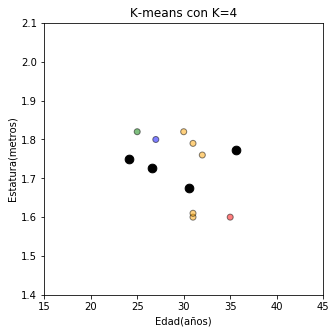

In [18]:
graficar_k_means(predicciones, centroides, colores)

[[0.    0.904 0.    0.096]
 [0.    0.65  0.    0.35 ]
 [0.775 0.016 0.    0.21 ]
 [1.    0.    0.    0.   ]
 [0.527 0.469 0.    0.004]
 [1.    0.    0.    0.   ]
 [0.995 0.005 0.    0.   ]
 [0.86  0.014 0.    0.126]]


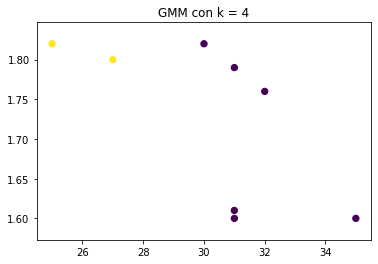

In [19]:
#Predicciones con Gaussian Mixture
#Calcular la probabilidad de pertenecer a cada clúster según GMM
data_test =pd.DataFrame(data_test, columns =["Estatura(metros)","Edad(años)"])
etiquetas = modelo_gm.predict(data_test)
probs = modelo_gm.predict_proba(data_test)
plt.scatter(data_test["Edad(años)"], data_test["Estatura(metros)"], c = etiquetas, s = 40, cmap = 'viridis')
plt.title("GMM con k = 4")
print(probs.round(3))

La diferencia entre ambos resultados obtenidos es que la persona en el datatest que mide 1.82 con 25 años de edad es clasificada en diferente cluster usando el metodo k-means mientras que con el metodo GMM, este es clasificado en el mismo cluster que los otros con estaturas similares.  

Es probable que escalando los datos mejoren las predicciones y los dos modelos coincidan.

### Parte 2: Detección de Anomalías

* Usar pestaña uno para hacer el entrenamiento del modelo de detección de anomalías.  
* Usar pestaña dos y tres como set de validación(seleccionar epsilon) y pruebas.

In [20]:
# Convertir a rray el set de datos de entrenamiento
data = np.array(data_train)

In [21]:
#Definición de la función para el modelo de detección de anomalías
def multivariate_gaussian(data):
    mu = np.mean(data, axis = 0)
    sigma = np.cov(data.T)
    dist = multivariate_normal(mu, sigma)
    pdf = dist.pdf(data)
    return mu, sigma, dist, pdf

In [22]:
#Función para graficar las anomalías obtenidas
def grafica_gauss(epsilon, data, pdf):
    plt.figure(figsize=(8,6))
    plt.scatter(data[:,1], data[:,0], marker="x",c=pdf, cmap='viridis');
    # identificamos las anomalías
    outliers = np.nonzero(pdf<epsilon)[0]
    plt.scatter(data[outliers,1], data[outliers,0], marker="o", facecolor="none", edgecolor="red",s=75)
    return outliers

#### Detección de anomalías

array([17, 21, 26], dtype=int64)

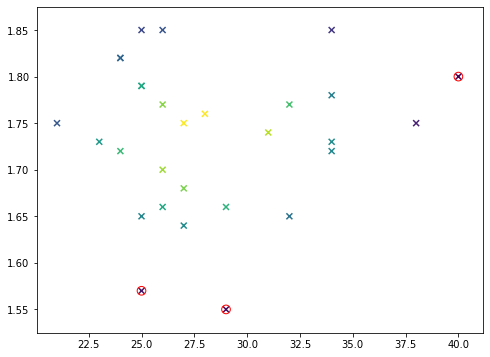

In [23]:
#Primero en el dataset de entrenamiento
_,_, _, probabilidades = multivariate_gaussian(data)
grafica_gauss(0.05, data, probabilidades)

Para el dataset de pruebas, los registros 17, 21 y 26 se salen del intervalo de confianza establecido, por lo cual se marcan como anomalías en la gráfica. 

array([], dtype=int64)

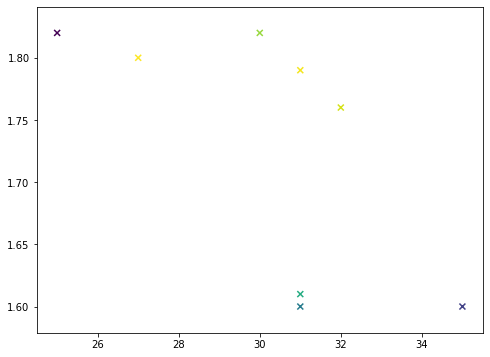

In [24]:
#Verificamos en el dataset para validación de la pestaña 2
data_val = np.array(data_test)
_,_, _, probabilidades_val = multivariate_gaussian(data_val)
grafica_gauss(0.05, data_val, probabilidades_val)

array([], dtype=int64)

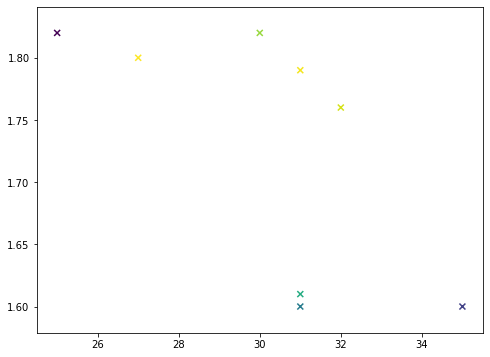

In [25]:
#Probamos ahora con un valor de epsilon más pequeño
grafica_gauss(0.025, data_val, probabilidades_val)

array([], dtype=int64)

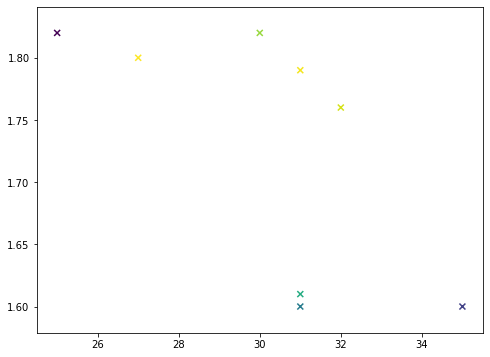

In [26]:
#Probamos ahora con un valor de epsilon más grande
grafica_gauss(0.075, data_val, probabilidades_val)

Para el dataset de validación, se realizaron tres experimentos con diferente valor de epsilon (0.05, 0.025, 0.075) y ningún registro se sale del intervalo de confianza, por lo cual no hay ninguna anomalía (todos los registros son normales). 

array([0, 1, 2, 3], dtype=int64)

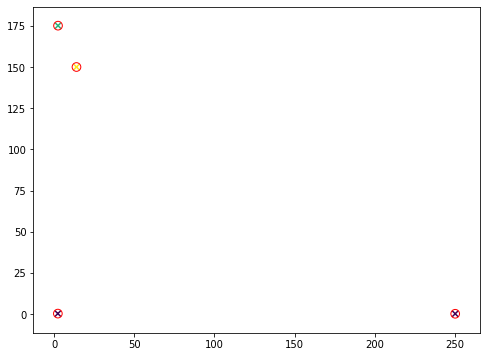

In [27]:
#Por último utilizaremos el dataset para pruebas de la pestaña 3
data_an = np.array(data_anomalias)
_,_, _, probabilidades_an = multivariate_gaussian(data_an)
grafica_gauss(0.025, data_an, probabilidades_an)

Para el caso del set de datos de anomalías, como su nombre lo indica, todos los registros de este dataset están fuera del intervalo de confianza.

Podemos concluir que después de realizar las pruebas en los set de datos correspondientes, y utilizando un modelo de detección de anomalías de Distribución Gausiana Multivariable, que un epsilon de 0.05 como punto umbral para detección de anomalías tiene un buen rendimiento de acuerdo a lo observado en los experimentos.